#### Imports

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset
import seaborn as sns

import matplotlib.pyplot as plt
import numpy as np
import os
import json
from datetime import datetime

#### Data Retrieval

In [ ]:
seed = 42

# Transformations will be added here.
transform = transforms.Compose(
    [transforms.ToTensor(),
     # Normalize the Data based on mean and std deviation of training data
    transforms.Normalize((0.519, 0.4992, 0.5140), (0.2090, 0.2375, 0.2462))]
)

traintestset = torchvision.datasets.ImageFolder(
        root = "./ASL_dataset/asl_alphabet_train/asl_alphabet_train",
        transform = transform
    )

# Train Validation Set
test_size = 0.1

# Get all the labels in traintestset
labels = np.array([label for _, label in traintestset.samples])

# Index Split across the labels
train_idx, test_idx = train_test_split(
    np.arange(len(labels)),
    test_size=test_size,
    stratify=labels,
    random_state=seed
)

# Get the subsets
trainset = Subset(traintestset, train_idx)
testset = Subset(traintestset, test_idx)

valset = torchvision.datasets.ImageFolder(
        root = "./ASL_dataset/asl_alphabet_test/asl_alphabet_test",
        transform = transform
    )

#### Device Init

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("Using device:", device)

Using device: cpu


#### CNN Def

In [3]:
class Net(nn.Module):
    def __init__(self,
                 activation="relu",
                 dropout_rate=0.0,
                 num_filters=[16, 32],
                 kernel_sizes=[3, 3]):

        super(Net, self).__init__()

        # select activation func
        if activation == "relu":
            self.act = nn.ReLU()
        elif activation == "leaky_relu":
            self.act = nn.LeakyReLU()
        elif activation == "gelu":
            self.act = nn.GELU()
        else:
            raise ValueError("Unknown activation", activation)

        # conv stack
        self.conv1 = nn.Conv2d(3, num_filters[0], kernel_size=kernel_sizes[0])
        self.conv2 = nn.Conv2d(num_filters[0], num_filters[1], kernel_size=kernel_sizes[1])

        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(dropout_rate)

        # final flat size
        example = torch.zeros(1, 3, 200, 200)
        with torch.no_grad():
            example = self.pool(self.act(self.conv1(example)))
            example = self.pool(self.act(self.conv2(example)))
            flat_size = example.numel()

        self.fc1 = nn.Linear(flat_size, 128)

        # 28 ASL letters total
        self.fc2 = nn.Linear(128, 28)

    def forward(self, x):
        x = self.pool(self.act(self.conv1(x)))
        x = self.pool(self.act(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.act(self.fc1(x))
        x = self.fc2(x)
        return x

In [4]:
print(Net(
        activation="relu",
        dropout_rate=0.25,
        num_filters=[16,32]
    ).to(device))

Net(
  (act): ReLU()
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.25, inplace=False)
  (fc1): Linear(in_features=73728, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=28, bias=True)
)


#### Hyperparamter Test Set

In [ ]:
# batch size modifications
group_A = [
    {"activation": "relu", "dropout": 0.25,  "lr": 0.001, "optimizer": "sgd", "weight_decay": 0.0,   "filters": [16,32], "batch_size": 32},
    {"activation": "relu", "dropout": 0.25, "lr": 0.001, "optimizer": "sgd", "weight_decay": 0.0,   "filters": [16,32], "batch_size": 128},
]

# learning rate modifications
group_B = [
    {"activation": "relu", "dropout": 0.25, "lr": 0.0001, "optimizer": "sgd", "weight_decay": 0.0,   "filters": [16,32], "batch_size": 64},
    {"activation": "relu", "dropout": 0.25, "lr": 0.0005, "optimizer": "sgd", "weight_decay": 0.0,   "filters": [16,32], "batch_size": 64},
    {"activation": "relu", "dropout": 0.25, "lr": 0.001,  "optimizer": "sgd", "weight_decay": 0.0,   "filters": [16,32], "batch_size": 64},
    {"activation": "relu", "dropout": 0.25, "lr": 0.005,  "optimizer": "sgd", "weight_decay": 0.0,   "filters": [16,32], "batch_size": 64},
    {"activation": "relu", "dropout": 0.25, "lr": 0.01,   "optimizer": "sgd", "weight_decay": 0.0,   "filters": [16,32], "batch_size": 64},
]

# optimizer modifications
group_C = [
    {"activation": "relu", "dropout": 0.25, "lr": 0.001,  "optimizer": "adam", "weight_decay": 0.0,   "filters": [16,32], "batch_size": 64},
    {"activation": "relu", "dropout": 0.25, "lr": 0.001,  "optimizer": "sgd", "weight_decay": 0.0,   "filters": [16,32], "batch_size": 64},
]

hyperparameter_sets = group_A + group_B + group_C

#### run_id gen

In [78]:
def make_run_id(params):
    base = (
        f"a-{params['activation']}"
        f"_d-{params['dropout']}"
        f"_lr-{params['lr']}"
        f"_opt-{params['optimizer']}"
        f"_wd-{params['weight_decay']}"
        f"_f-{params['filters']}"
        f"_bs-{params['batch_size']}"
    )

    return f"{base}"

#### Directory for Results


In [79]:
if not os.path.exists("experiment_runs"):
    os.makedirs("experiment_runs")

#### Optimizer

In [80]:
def create_optimizer(params, name, lr, weight_decay):
    if name == "adam":
        return optim.Adam(params, lr=lr, weight_decay=weight_decay)
    elif name == "sgd":
        return optim.SGD(params, lr=lr, momentum=0.9, weight_decay=weight_decay)
    else:
        raise ValueError("Unknown optimizer:", name)

#### Training Func

In [81]:
def train_model(run_id, params, trainloader, validloader, testloader, epochs=15):

    # record storage
    train_losses = []
    train_accs = []
    valid_accs = []

    # model
    net = Net(
        activation=params["activation"],
        dropout_rate=params["dropout"],
        num_filters=params["filters"]
    ).to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = create_optimizer(net.parameters(), params["optimizer"],
                                 params["lr"], params["weight_decay"])

    for epoch in range(epochs):

        # for analytics
        running_loss = 0.0
        temp_running_loss = 0.0
        correct = 0
        total = 0

        net.train()
        for i, data in enumerate(trainloader, 0):

            inputs, labels = data[0].to(device), data[1].to(device)

            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            temp_running_loss += loss.item()

            # accuracy
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            if i % 1999 == 2000:
                print(f"[Run {run_id}] Epoch {epoch+1}, Batch {i+1} — Loss: {temp_running_loss/2000:.3f}")
                temp_running_loss = 0.0

        # epoch metrics
        train_losses.append(running_loss / len(trainloader))
        train_accs.append(100 * correct / total)

        # valid loop
        net.eval()
        correct_test = 0
        total_test = 0
        with torch.no_grad():
            for data in validloader:
                images, labels = data[0].to(device), data[1].to(device)
                outputs = net(images)
                _, predicted = outputs.max(1)
                total_test += labels.size(0)
                correct_test += predicted.eq(labels).sum().item()

        valid_acc = 100 * correct_test / total_test
        valid_accs.append(valid_acc)

        print(f"[Run {run_id}] Epoch {epoch+1} — Train Acc: {train_accs[-1]:.2f}%  Valid Acc: {valid_acc:.2f}%")

    print("Finished Training Run", run_id)
    
    # test accuracy loop
    net.eval()
    correct_test = 0
    total_test = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = net(images)
            _, predicted = outputs.max(1)
            total_test += labels.size(0)
            correct_test += predicted.eq(labels).sum().item()
            # Add correct labels
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    test_acc = 100 * correct_test / total_test
    
    precision = precision_score(all_labels, all_preds, average='macro')
    recall = recall_score(all_labels, all_preds, average='macro')
    f1 = f1_score(all_labels, all_preds, average='macro')
    cm = confusion_matrix(all_labels, all_preds)

    # save model
    model_path = f"experiment_runs/model_run_{run_id}.pt"
    torch.save(net.state_dict(), model_path)

    # save metrics
    history = {
        "params": params,
        "train_loss": train_losses,
        "train_acc": train_accs,
        "valid_acc": valid_accs,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "cm": cm.tolist()
    }

    json_path = f"experiment_runs/history_run_{run_id}.json"
    with open(json_path, "w") as f:
        json.dump(history, f, indent=4)

    return history

#### Run All

In [82]:
all_histories = {}

for run_id, hp in enumerate(hyperparameter_sets):

    run_id = make_run_id(hp)

    print("\n------------------------------------")
    print("Starting Run", run_id)
    print("Hyperparameters:", hp)
    print("------------------------------------\n")

    trainloader = torch.utils.data.DataLoader(trainset, batch_size=hp["batch_size"],
                                        shuffle=True, num_workers=2)

    valloader = torch.utils.data.DataLoader(valset, batch_size=hp["batch_size"],
                                            shuffle=True, num_workers=2)
    
    testloader = torch.utils.data.DataLoader(testset, batch_size=hp["batch_size"],
                                            shuffle=True, num_workers=2)

    history = train_model(run_id, hp, trainloader, valloader, testloader, epochs=50)
    all_histories[run_id] = history


------------------------------------
Starting Run a-relu_d-0.25_lr-0.001_opt-adam_wd-0.0_f-[16, 32]_bs-64
Hyperparameters: {'activation': 'relu', 'dropout': 0.25, 'lr': 0.001, 'optimizer': 'adam', 'weight_decay': 0.0, 'filters': [16, 32], 'batch_size': 64}
------------------------------------

[Run a-relu_d-0.25_lr-0.001_opt-adam_wd-0.0_f-[16, 32]_bs-64] Epoch 1 — Train Acc: 10.71%  Valid Acc: 14.29%
Finished Training Run a-relu_d-0.25_lr-0.001_opt-adam_wd-0.0_f-[16, 32]_bs-64


C:\Users\chris\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



------------------------------------
Starting Run a-relu_d-0.25_lr-0.001_opt-sgd_wd-0.0_f-[16, 32]_bs-64
Hyperparameters: {'activation': 'relu', 'dropout': 0.25, 'lr': 0.001, 'optimizer': 'sgd', 'weight_decay': 0.0, 'filters': [16, 32], 'batch_size': 64}
------------------------------------

[Run a-relu_d-0.25_lr-0.001_opt-sgd_wd-0.0_f-[16, 32]_bs-64] Epoch 1 — Train Acc: 3.57%  Valid Acc: 3.57%
Finished Training Run a-relu_d-0.25_lr-0.001_opt-sgd_wd-0.0_f-[16, 32]_bs-64


C:\Users\chris\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### Graphs

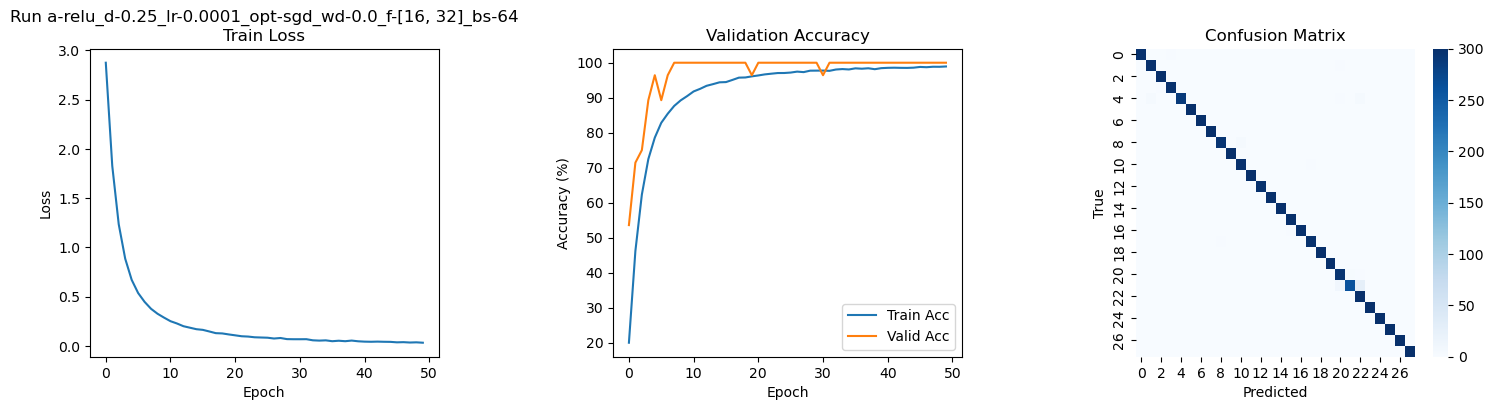

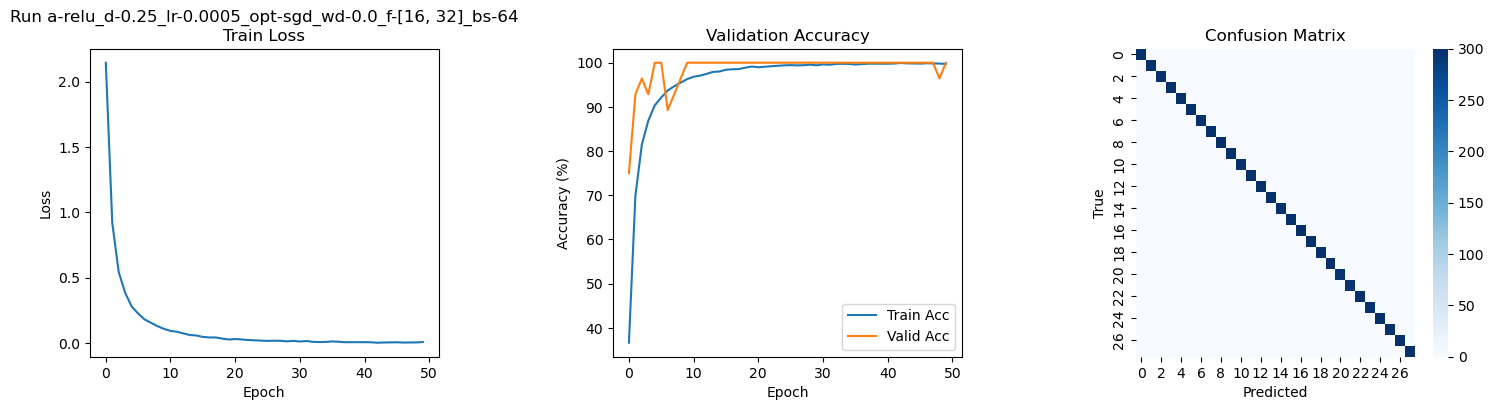

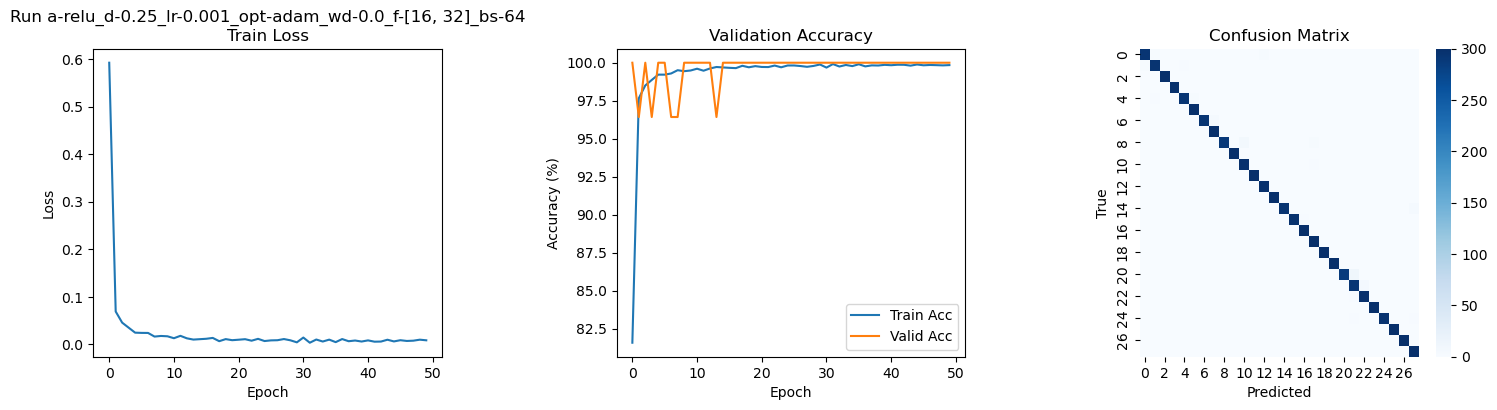

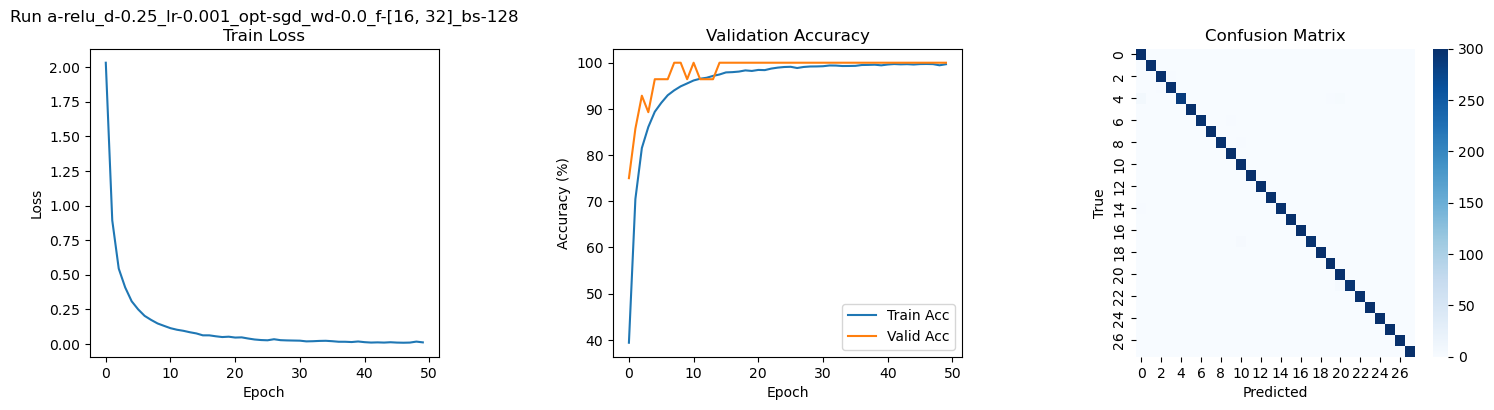

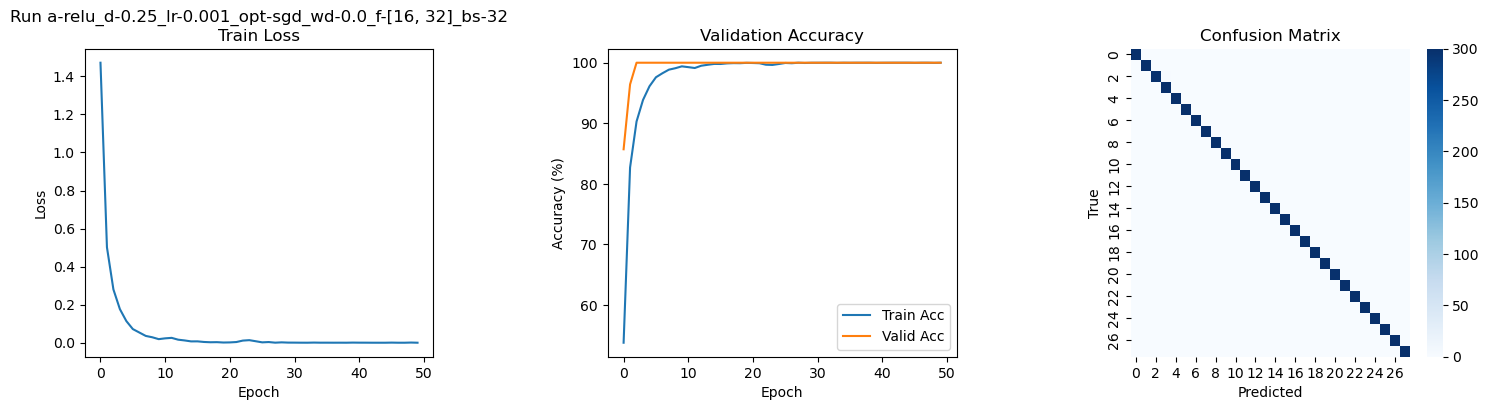

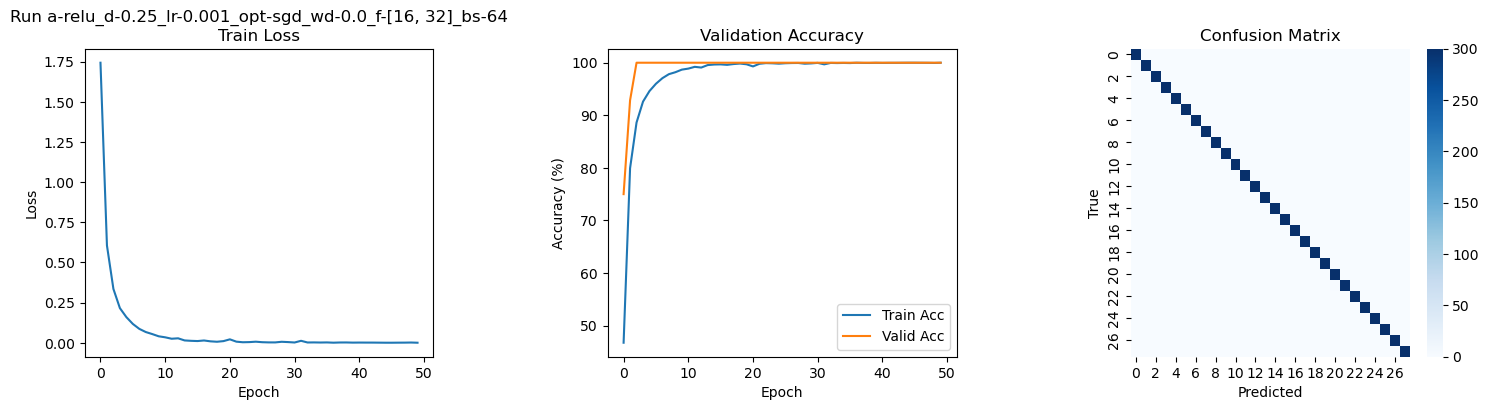

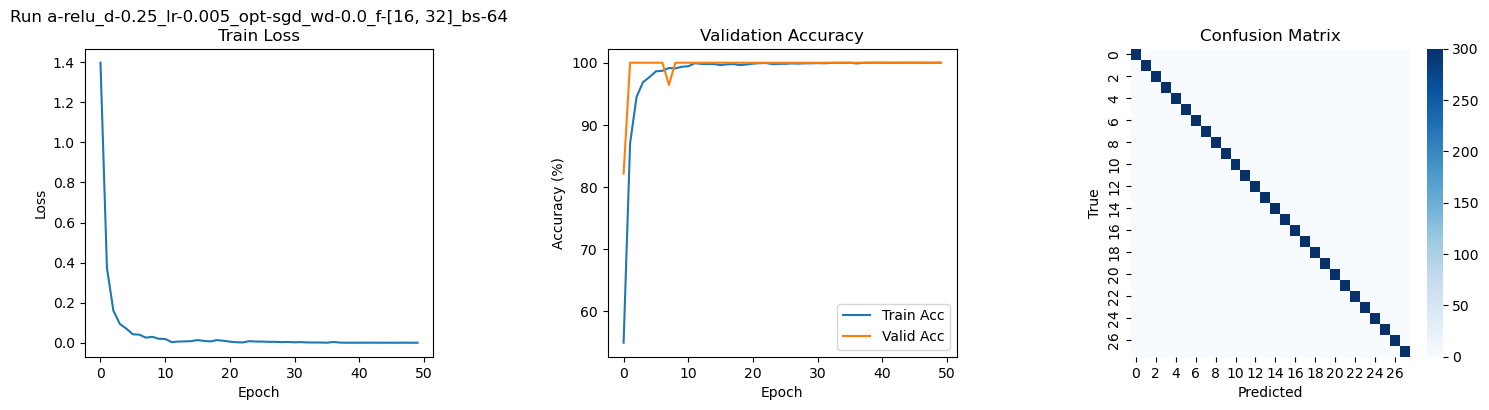

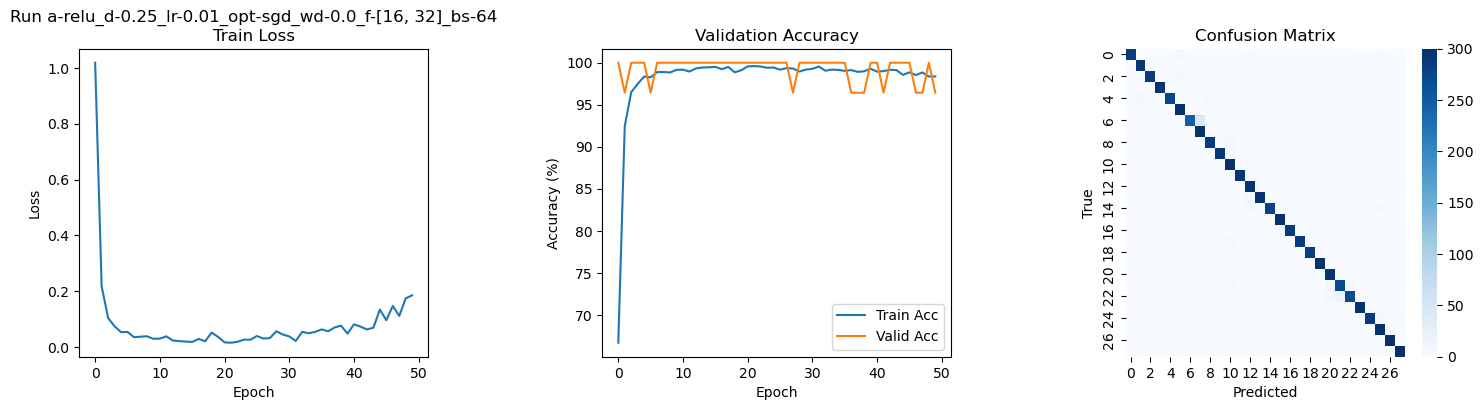

In [3]:
import json

def load_all_histories():
    histories = {}
    for file in os.listdir("experiment_runs"):
        if file.startswith("history_run_") and file.endswith(".json"):
            run_id = file[len("history_run_"):-len(".json")]
            with open(os.path.join("experiment_runs", file), "r") as f:
                histories[run_id] = json.load(f)
    return histories

histories = load_all_histories()

# plot
for run_id, h in histories.items():
    plt.figure(figsize=(18,4))

    # loss
    plt.subplot(1,3,1)
    plt.plot(h["train_loss"])
    plt.title(f"Run {run_id}\nTrain Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")

    # accuracy
    plt.subplot(1,3,2)
    plt.plot(h["train_acc"], label="Train Acc")
    plt.plot(h["valid_acc"], label="Valid Acc")
    plt.title(f"Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.legend()
    
    # confusion matrix
    plt.subplot(1,3,3)
    sns.heatmap(h["cm"], annot=False, fmt="d", cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"Confusion Matrix")

    # increase horizontal spacing
    plt.subplots_adjust(wspace=0.5)  
    plt.show()
